### RNG and (width, height) distributions

In [1]:
import numpy as np
from numpy.random._generator import Generator
import functools
from SquareDivision.src.distributions import x_plus_y_func
from SquareDivision.config import config

rng:Generator = np.random.default_rng(config['seed'])
func = functools.partial(x_plus_y_func, 
                         min_00=0.025, max_00=0.03,
                         min_11=0.2, max_11=0.3,
                         rng=rng)

### Random rectangulation and inflating to clinch

In [2]:
from SquareDivision.src.generators import uniform_pts
from SquareDivision.src.dataflow import arg_rect_list, process

# rng:Generator = np.random.default_rng(config['seed'])
arr = arg_rect_list(10, uniform_pts, func, rng=rng)
arr, pushed_arr = process(arr)

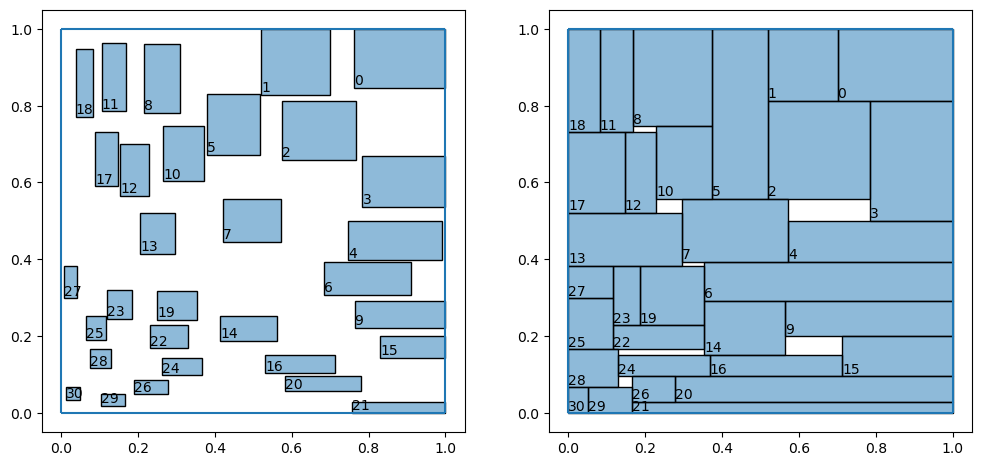

In [3]:
import matplotlib.pyplot as plt
from SquareDivision.draw.draw import draw_rectangles, rectangle_numbers# , set_settings#, draw_suspended_walls
from SquareDivision.src.regions import opposing_walls_in_half_plane_in_dir

# suspect, direction = 5, 'u'
# which_list, sus_walls = opposing_walls_in_half_plane_in_dir(suspect, arr, direction)
# ax = draw_suspended_walls(ax, direction, sus_walls)

import matplotlib.pyplot as plt
from SquareDivision.draw.draw import draw_rectangles

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0] = draw_rectangles(axes[0], arr[:,:4])
axes[0] = rectangle_numbers(axes[0], arr[:,:4])
axes[1] = draw_rectangles(axes[1], pushed_arr[:,:4])
axes[1] = rectangle_numbers(axes[1], pushed_arr[:,:4])
plt.show()
clinched_rectangles = pushed_arr[:,:4]

#### contact matricies

In [32]:
from SquareDivision.contact_graph.incidence_matrix import (
    numers_of_contacting_rectangles_in_dir,
    contact_graph_incidence_matrix
)
# np.where(numers_of_contacting_rectangles_in_dir(9, clinched_rectangles, 'r')>0)
print(np.where(contact_graph_incidence_matrix(clinched_rectangles, 'u') > 0))
east_neighbours = contact_graph_incidence_matrix(clinched_rectangles, 'r').astype(int)
north_neighbours=contact_graph_incidence_matrix(clinched_rectangles, 'u').astype(int)

(array([ 2,  2,  3,  4,  6,  6,  7,  7,  7,  9, 10, 12, 13, 13, 14, 15, 16,
       17, 17, 19, 20, 20, 20, 21, 21, 22, 22, 23, 24, 25, 26, 27, 28, 28,
       29, 30], dtype=int64), array([ 0,  1,  0,  3,  4,  7,  2,  5, 10,  6,  8, 11, 12, 17,  6,  9, 14,
       11, 18, 13, 15, 16, 24, 20, 26, 19, 23, 13, 14, 27, 24, 13, 22, 25,
       28, 28], dtype=int64))


In [59]:
import networkx as nx
import itertools
from networkx.algorithms.cycles import simple_cycles
from SquareDivision.holes.detect import find_holes
graph_undir = find_holes(clinched_rectangles, east_neighbours, north_neighbours)
planarQ, graph_plan = nx.check_planarity(graph_undir)
potential_holes_0 = [set(cycle) for cycle in nx.cycle_basis(graph_undir) if len(cycle) == 4]
potential_holes_1 = [set(cycle) for cycle in nx.cycle_basis(graph_plan) if len(cycle) == 4]
print(potential_holes_0)
print(potential_holes_1)
pairs = list(itertools.product(potential_holes_0, potential_holes_1))
fin=[]
for set_of_nodes_0 in potential_holes_0:
    for set_of_nodes_1 in potential_holes_1:
        if set_of_nodes_1 == set_of_nodes_0:
            continue
        elif set_of_nodes_1 not in fin:
            fin.append(set_of_nodes_1)
    if set_of_nodes_0 not in fin:
        fin.append(set_of_nodes_0)
fin



[{24, 26, 28, 29}, {16, 9, 14, 15}, {19, 13, 6, 7}, {8, 10, 11, 12}]
[{16, 9, 14, 15}, {2, 3, 4, 7}, {8, 10, 11, 12}, {19, 13, 6, 7}]


[{9, 14, 15, 16},
 {2, 3, 4, 7},
 {8, 10, 11, 12},
 {6, 7, 13, 19},
 {24, 26, 28, 29}]

In [56]:
{24, 26, 28, 29} == {24, 26, 29,28}

True

In [44]:
import networkx as nx
from networkx.algorithms import planarity as planty
# G = planty.PlanarEmbedding(graph)
planarQ, graph_plan = nx.check_planarity(graph_undir)

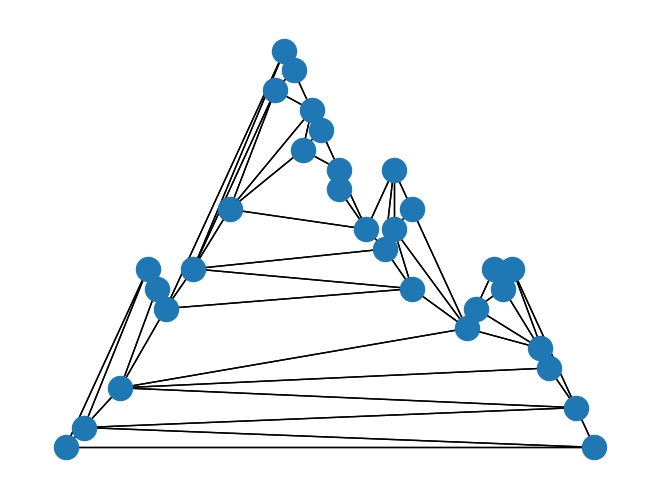

In [45]:
nx.draw_planar(G)

In [29]:
potential_holes = [cycle for cycle in nx.cycle_basis(graph_undir) if len(cycle) == 4]
potential_holes

[[28, 24, 26, 29], [14, 9, 15, 16], [7, 13, 19, 6], [12, 10, 8, 11]]

In [17]:
list_of_rows = [np.array([0,0,1]), np.array([0,1,1])]
np.r_[list_of_rows]

array([[0, 0, 1],
       [0, 1, 1]])

## Projection onto retrangulation without holes

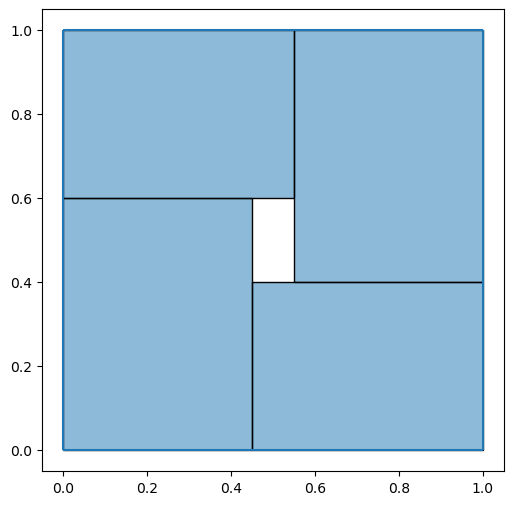

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from SquareDivision.draw.draw import draw_rectangles


width, height = np.array([0.1, 0.2]) / 2
rect_area = (0.5 - width)*(0.5 + height)
arr_with_hole = np.array([
    [          0,            0, 0.5 - width, 0.5 + height, (0.5 - width) * (0.5 + height)],
    [          0, 0.5 + height, 0.5 + width, 0.5 - height, (0.5 + width) * (0.5 - height)],
    [0.5 + width, 0.5 - height, 0.5 - width, 0.5 + height, (0.5 - width) * (0.5 + height)],
    [0.5 - width,            0, 0.5 + width, 0.5 - height, (0.5 + width) * (0.5 - height)],
])
#additional name for future
clinched_rectangles = arr_with_hole
fig, ax = plt.subplots(figsize=(6, 6))
ax = draw_rectangles(ax, arr_with_hole)
plt.show()

east_neighbours = np.array([
    [0,0,0,1],
    [0,0,1,0],
    [0,0,0,0],
    [0,0,0,0]
])
north_neighbours = np.array([
    [0,1,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,1,0]
])

In [39]:
arr_with_hole

array([[0.  , 0.  , 0.4 , 0.55, 0.22],
       [0.  , 0.55, 0.6 , 0.45, 0.27],
       [0.6 , 0.45, 0.4 , 0.55, 0.22],
       [0.4 , 0.  , 0.6 , 0.45, 0.27]])

### condition building on `[x, y, width, height, area]` such that:
sum of areas is 1, apropriate sums of height and width are 1, first build matrix `A`

In [2]:
east_neighbours = np.array([
    [0,0,0,1],
    [0,0,1,0],
    [0,0,0,0],
    [0,0,0,0]
])
north_neighbours = np.array([
    [0,1,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,1,0]
])


#### bounds

In [10]:
def bounds_from_clinched(clinched_rectangles:np.ndarray):
    n, m = clinched_rectangles.shape
    lb = np.zeros(shape= n * 5)
    ub = np.ones(shape= n * 5)
    for num, row in enumerate(clinched_rectangles):
        idx = 5 * num
        if np.isclose(row[0], 0) and np.isclose(row[1], 0): 
            lb[idx], ub[idx], lb[idx+1], ub[idx+1] = 0, 0, 0, 0
            continue # keep (0,0) corner
        elif np.isclose(row[0], 0) and (not np.isclose(row[1], 0)):
            lb[idx], ub[idx] = 0, 0 
            continue # keep-left
        elif (not np.isclose(row[0], 0)) and np.isclose(row[1], 0):
            lb[idx+1], ub[idx+1] = 0, 0
            continue # keep-bottom
        else:
            continue
    return lb, ub
        

In [11]:
from scipy.optimize import Bounds
lb, ub = bounds_from_clinched(clinched_rectangles)
bounds = Bounds(lb=lb, ub=ub, keep_feasible=np.array([True]*20))

#### New functions fo constraints

In [14]:
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from SquareDivision.optimization.constraints import (
    low_boundary_constraint_args,
    high_boundary_constraint_args,
    contact_constraint_args,
    area_constraint_fun,
    area_jac
)
from SquareDivision.optimization.objective_function import (
    dist_fun
)
from SquareDivision.optimization.initial_guess import (
    contact_universal_x0
)

In [17]:
clinched_rectangles = clinched_rectangles[:,:4]
low__X_A, low__X_rhs = low_boundary_constraint_args(clinched_rectangles, east_neighbours, axis=0)
low__Y_A, low__Y_rhs = low_boundary_constraint_args(clinched_rectangles, north_neighbours, axis=1)
high_X_A, high_X_rhs = high_boundary_constraint_args(clinched_rectangles, east_neighbours, axis=0)
high_Y_A, high_Y_rhs = high_boundary_constraint_args(clinched_rectangles, north_neighbours, axis=1)
low__X_constr = LinearConstraint( A=low__X_A, lb=low__X_rhs, ub=low__X_rhs)
low__Y_constr = LinearConstraint( A=low__Y_A, lb=low__Y_rhs, ub=low__Y_rhs)
high_X_constr = LinearConstraint( A=high_X_A, lb=high_X_rhs, ub=high_X_rhs)
high_Y_constr = LinearConstraint( A=high_Y_A, lb=high_Y_rhs, ub=high_Y_rhs)

cont_X_A, cont_X_rhs = contact_constraint_args(clinched_rectangles, east_neighbours, axis=0)
cont_Y_A, cont_Y_rhs = contact_constraint_args(clinched_rectangles, north_neighbours, axis=1)
horizontal_contacts = LinearConstraint( A=cont_X_A, lb=cont_X_rhs, ub=cont_X_rhs)
vertical___contacts = LinearConstraint( A=cont_Y_A, lb=cont_Y_rhs, ub=cont_Y_rhs)

area_constr = NonlinearConstraint(fun=area_constraint_fun, jac=area_jac, lb=0, ub=0)
constraints = [
    low__X_constr, low__Y_constr,
    high_X_constr, high_Y_constr,
    horizontal_contacts,
    vertical___contacts,
    area_constr]

x0 = contact_universal_x0(clinched_rectangles=clinched_rectangles).flatten()

In [26]:
from scipy.optimize import minimize
# x0 = build_x0(arr_with_hole)
# x0 = x0_cross_ab(0.2,0.3)
# x0 = contact_universal_x0(clinched_rectangles).flatten()
sol = minimize(dist_fun, x0=clinched_rectangles.flatten(), args=(clinched_rectangles), jac=True, method='trust-constr', constraints=constraints)#, bounds=bounds)

d:\Users\jg255\anaconda3\envs\ray310\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [25]:
sol#.x.reshape(-1,4)

          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: 0.017706423402982025
                x: [-1.706e-32  5.144e-32 ...  4.997e-01  4.216e-01]
              nit: 16
             nfev: 8
             njev: 8
             nhev: 0
         cg_niter: 0
     cg_stop_cond: 1
             grad: [-3.412e-32  1.029e-31 ... -1.007e-01  4.313e-02]
  lagrangian_grad: [ 0.000e+00  1.110e-16 ... -6.667e-04  4.313e-02]
           constr: [array([-1.706e-32,  0.000e+00, ...,  0.000e+00,
                           0.000e+00]), array([ 0.000e+00,  5.144e-32, ...,  0.000e+00,
                           0.000e+00]), array([ 0.000e+00,  0.000e+00, ...,  0.000e+00,
                           0.000e+00]), array([ 0.000e+00,  0.000e+00, ...,  0.000e+00,
                           0.000e+00]), array([ 0.000e+00,  0.000e+00]), array([ 0.000e+00,  0.000e+00]), array([ 0.000e+00])]
              jac: [array([[ 1.000e+00,  0.000e+00, ...,  0.

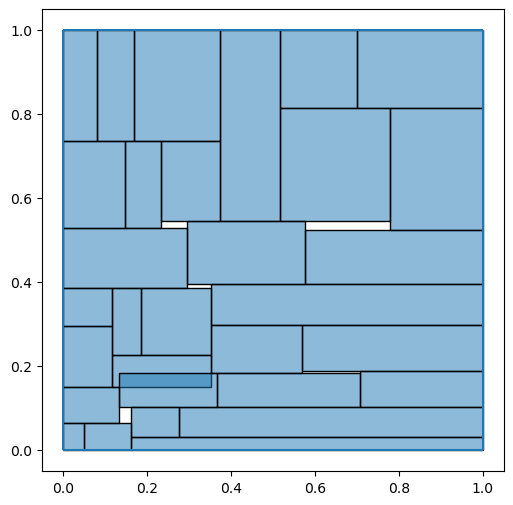

In [29]:

rects_sol = sol.x.reshape(-1,4)
fig, ax = plt.subplots(figsize=(6, 6))
# ax = draw_rectangles(ax, np.c_[rects_sol,np.array([0,0,0,0])])
# ax = draw_rectangles(ax, clinched_rectangles)
ax = draw_rectangles(ax, rects_sol)

plt.show()

In [32]:
(rects_sol[:,2]*rects_sol[:,3]).sum()

0.9999999999999998